In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import * 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LassoLarsCV
from scipy.optimize import minimize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [6]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
df = df.drop(['id','CustomerId'], axis=1)

In [8]:
df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [9]:
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
target = df['Exited']

<font size=5>**EDA**</font>

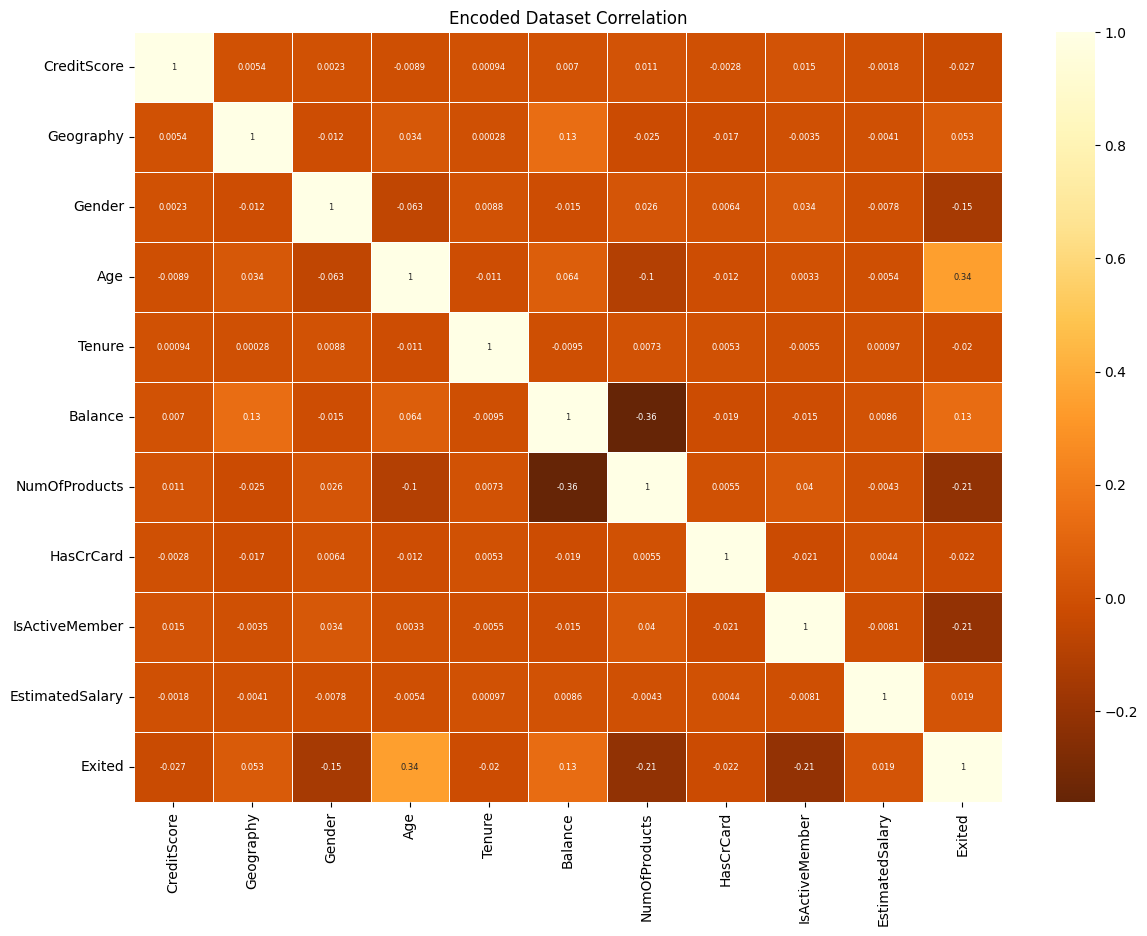

In [10]:
# Create a copy of the dataframe
df_encoded = df.drop(['Surname'], axis=1).copy()

# Label encode categorical columns
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    label_encoders[column] = le

def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str = 'Train correlation') -> None:
    excluded_columns = []
    columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
    corr = df[columns_without_excluded].corr()
    
    fig, axes = plt.subplots(figsize=(14, 10))
    sns.heatmap(corr, linewidths=.5, cmap='YlOrBr_r', annot=True, annot_kws={"size": 6})
    plt.title(title_name)
    plt.show()

# Plot correlation heatmap for encoded dataframe
plot_correlation_heatmap(df_encoded, 'Encoded Dataset Correlation')

<Figure size 1600x1600 with 0 Axes>

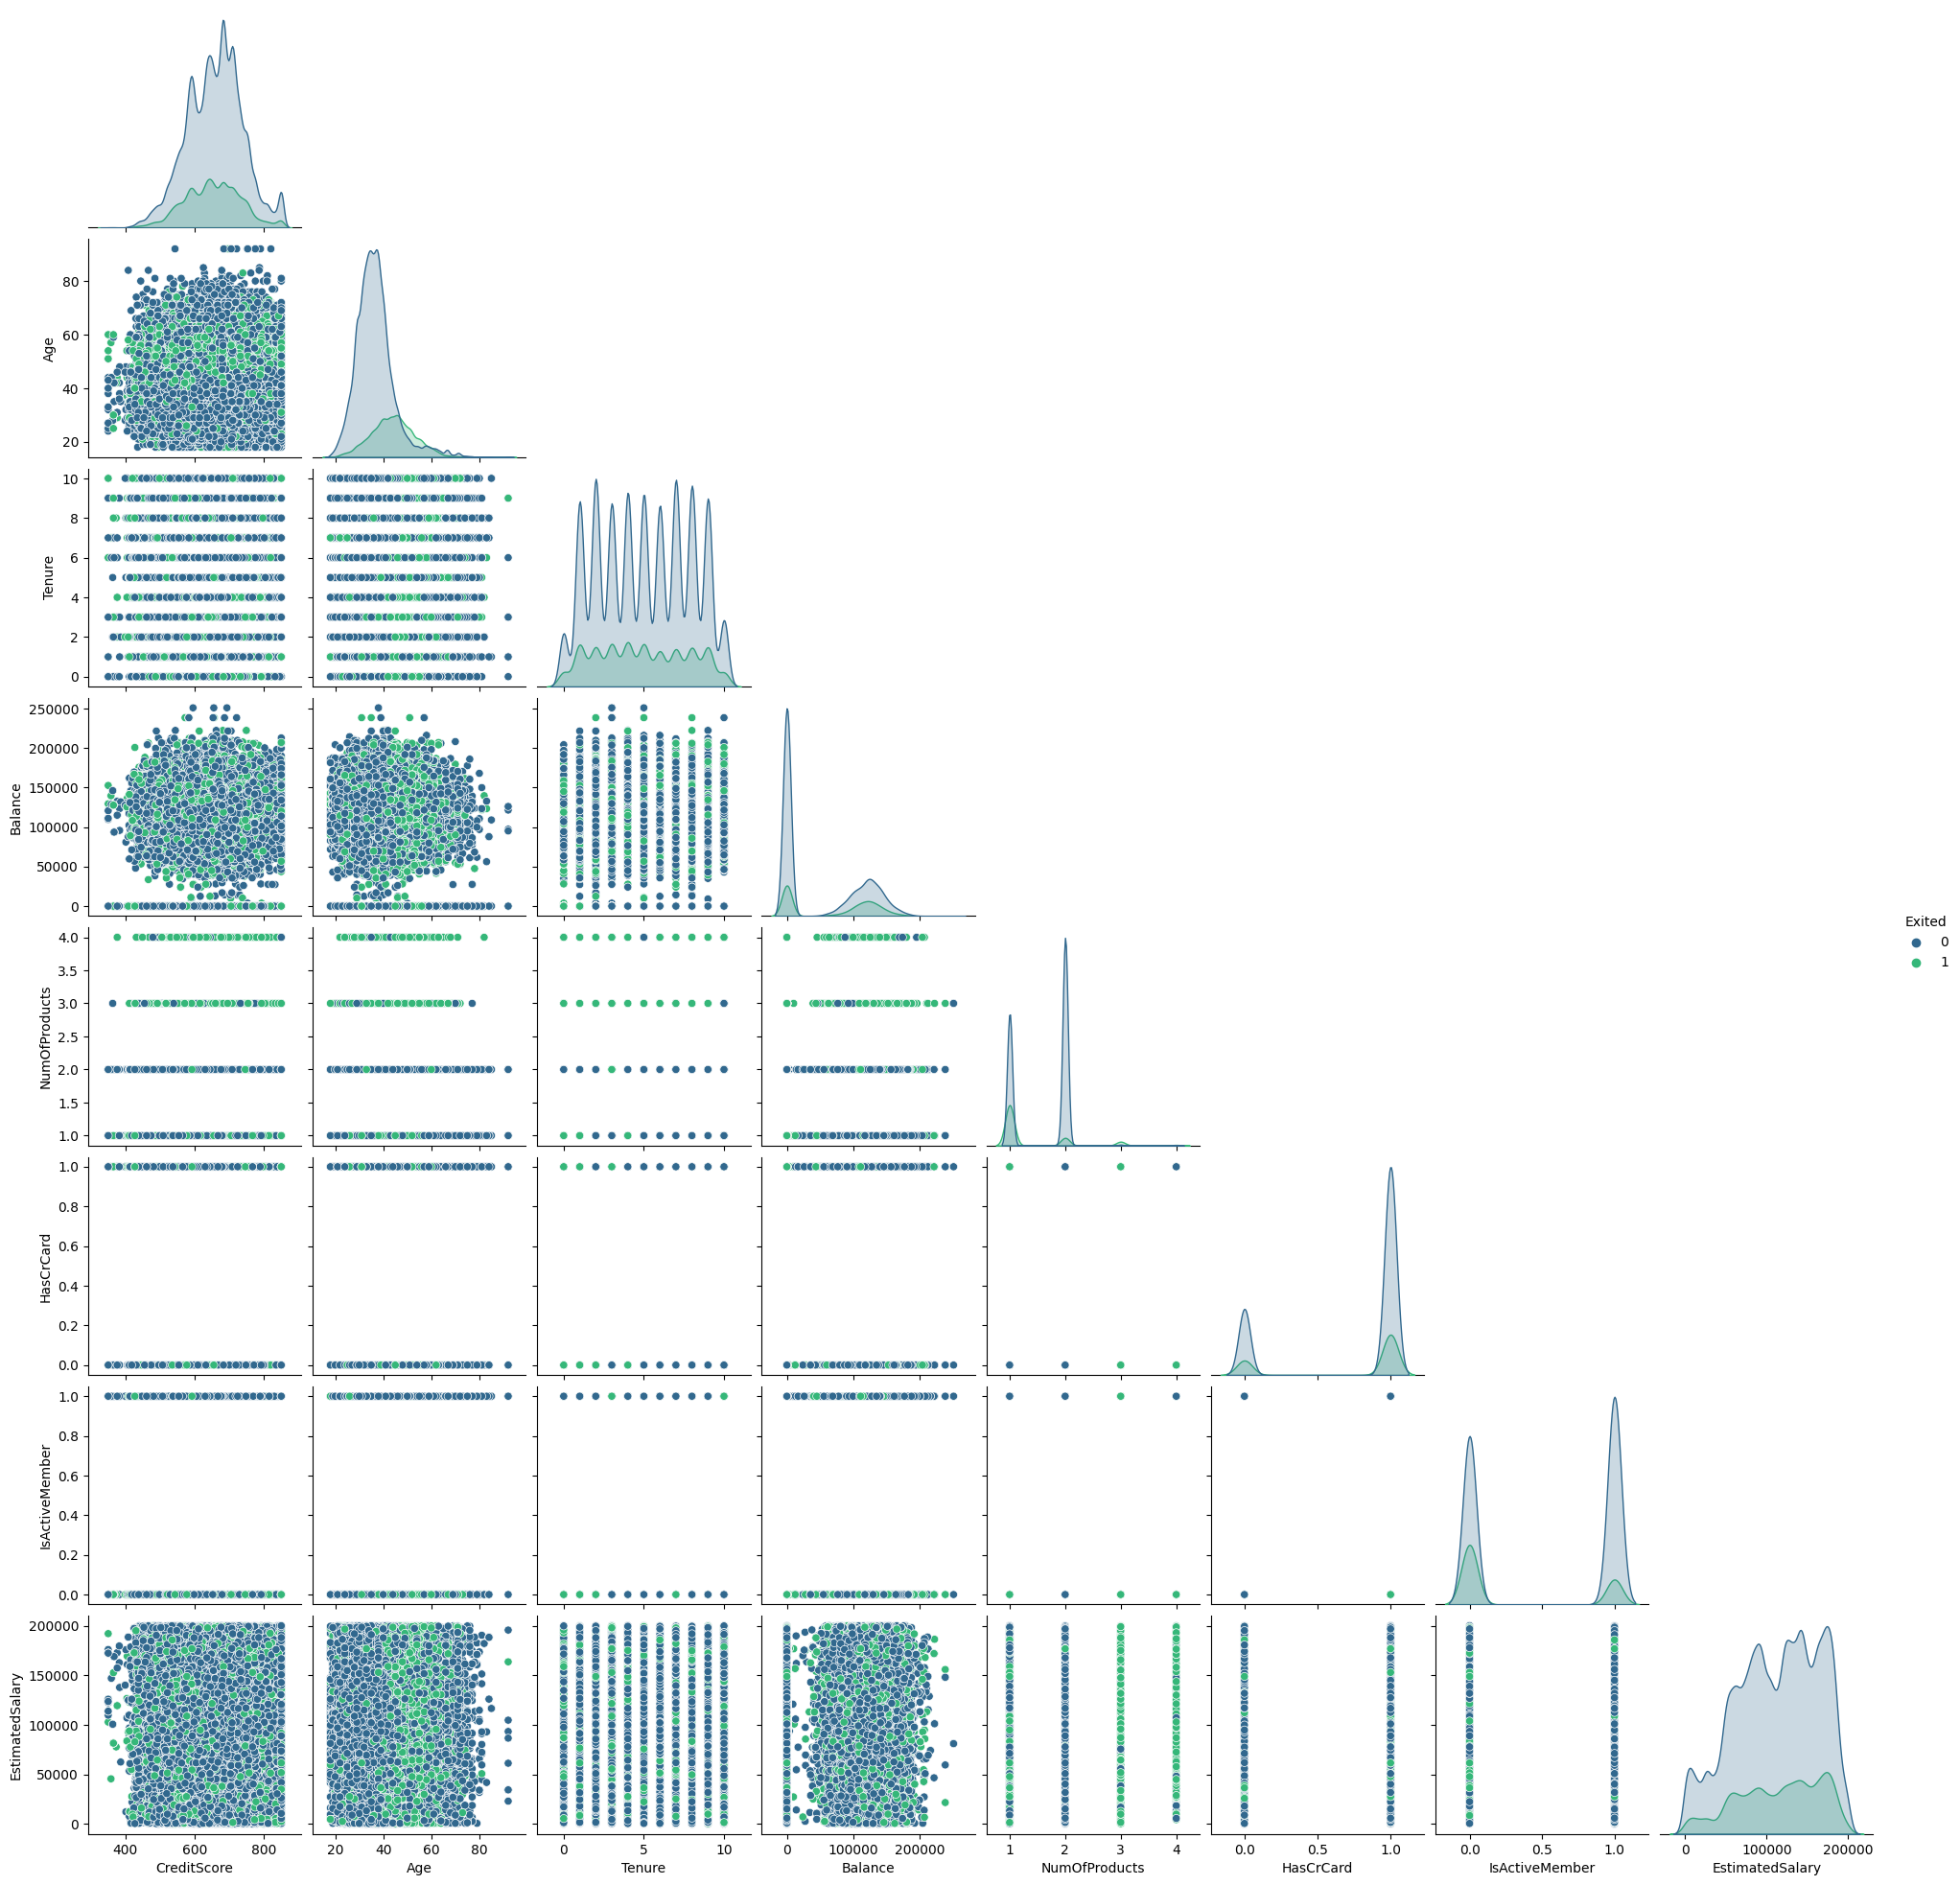

In [11]:
plt.figure(figsize=(16, 16))
sns.pairplot(data=df.drop(['Surname'],axis=1), hue="Exited", corner=True, palette="viridis")
plt.grid(None)
plt.show()

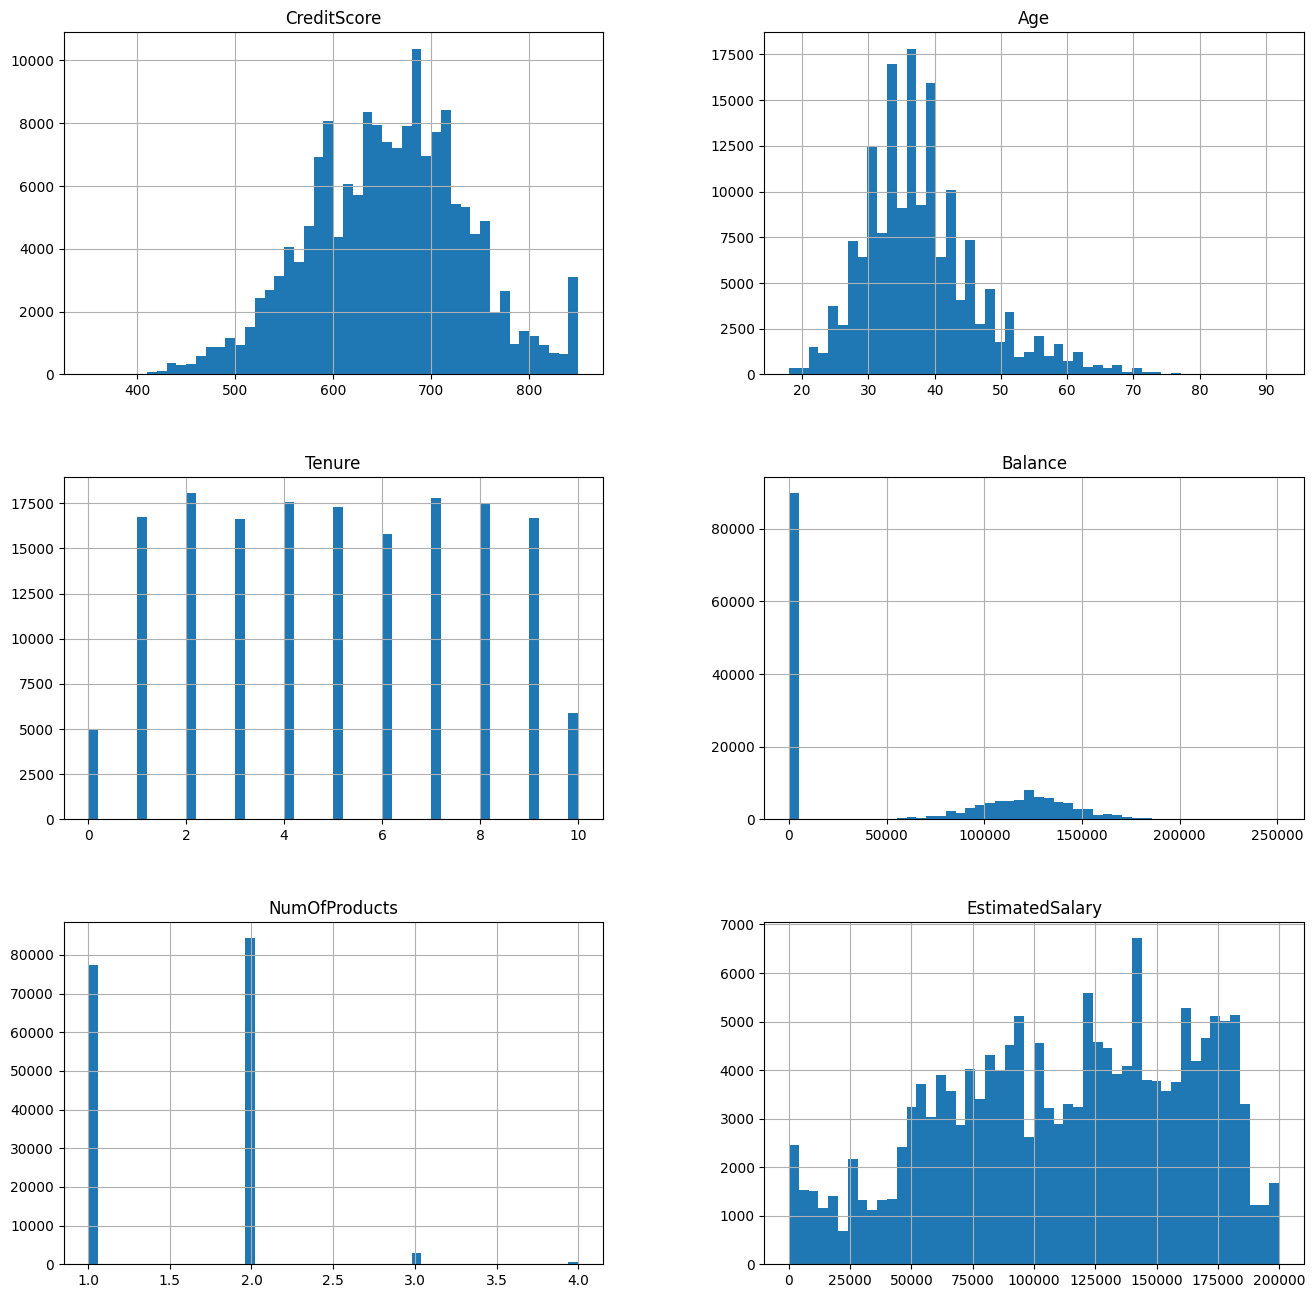

In [12]:
df[num_cols].hist(bins=50, figsize=(16,16))
plt.show()

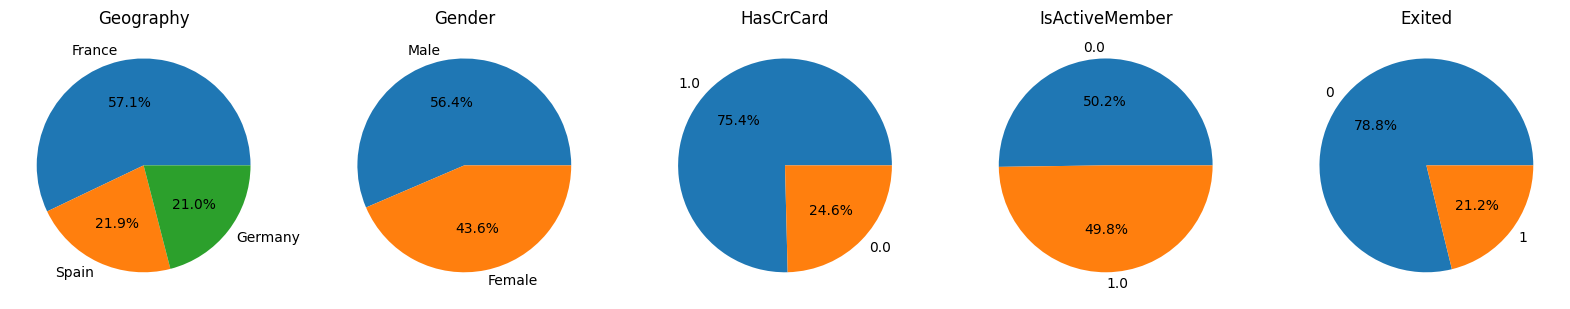

In [13]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 15))
for ax, col in zip(axes.flatten(), cat_cols+['Exited']):
    ax.set_title(col)
    ax.pie(df[col].value_counts(), autopct="%1.1f%%", labels=df[col].value_counts().index)

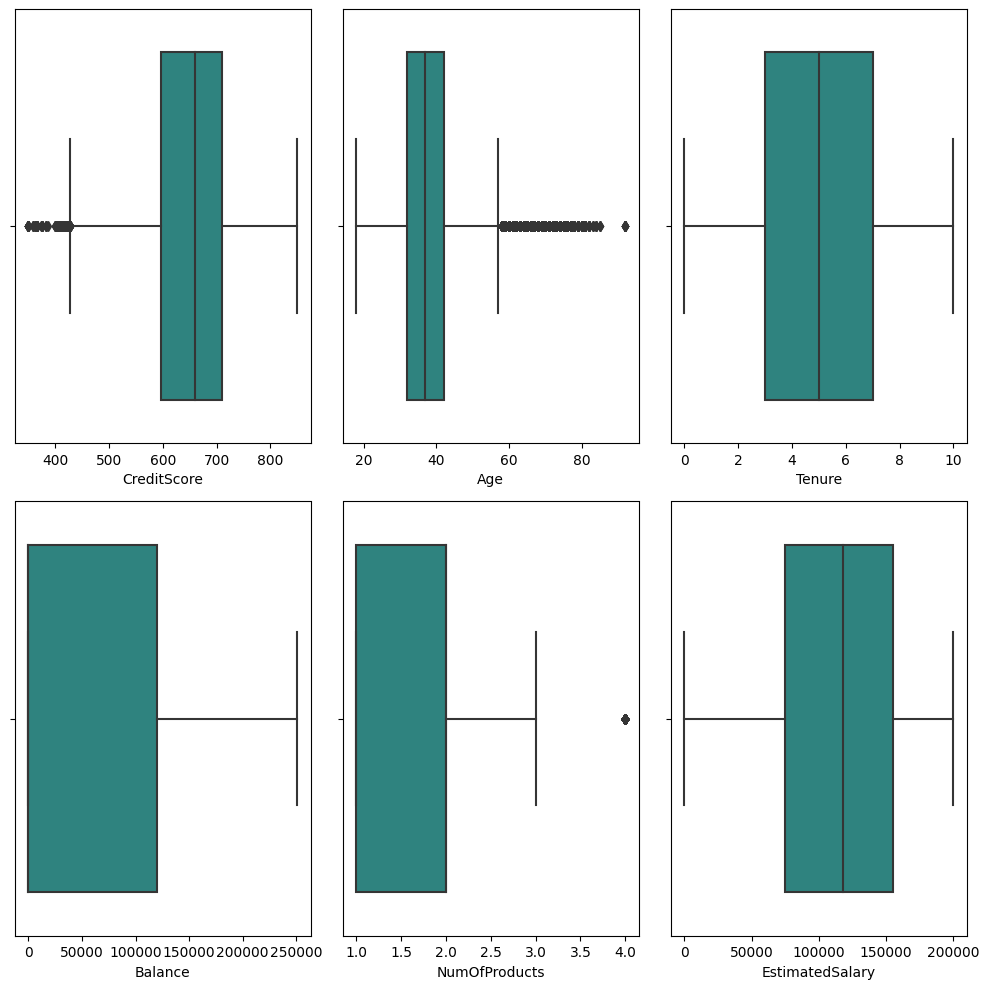

In [14]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(10,10))
i=0
for feature in num_cols:
    n=i//3
    m=i%3
    sns.boxplot(x=feature,data=df,ax=ax[n,m],palette='viridis')
    i+=1
    plt.tight_layout()

<font size=5>*Mini Feature Engineering and Data Preprocessing*</font>

In [15]:
df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [16]:
def feature_gen(df, num_cols, cat_cols):
    tfidf = TfidfVectorizer(max_features=1000)
    sparse_matrix_train = tfidf.fit_transform(df['Surname'])
    svd = TruncatedSVD(5)
    pca_train = svd.fit_transform(sparse_matrix_train)
    
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(pca_train,columns=['svd1','svd2','svd3','svd4','svd5'])], axis=1)

    df["Cred_Bal_Sal"] = (df["CreditScore"] * df["Balance"] ) / df["EstimatedSalary"]
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['BalanceIsZero'] = (df['Balance'] == 0).astype(int)
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df = pd.concat([df, pd.get_dummies(df['Geography']).astype('category')], axis=1)
    
    cat_cols.extend(['IsActive_by_CreditCard', 'AgeCat', 'BalanceIsZero'])
    num_cols.extend(['Products_Per_Tenure', "Cred_Bal_Sal", 'TotalProductsUsed','svd1','svd2','svd3','svd4','svd5'])
    return df, num_cols, cat_cols

In [17]:
df, num_cols, cat_cols = feature_gen(df, num_cols, cat_cols)

In [18]:
df['Geography'] = df['Geography'].astype('category')
df['Gender'] = df['Gender'].astype('category')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Surname                 165034 non-null  object  
 1   CreditScore             165034 non-null  int64   
 2   Geography               165034 non-null  category
 3   Gender                  165034 non-null  category
 4   Age                     165034 non-null  float64 
 5   Tenure                  165034 non-null  int64   
 6   Balance                 165034 non-null  float64 
 7   NumOfProducts           165034 non-null  int64   
 8   HasCrCard               165034 non-null  float64 
 9   IsActiveMember          165034 non-null  float64 
 10  EstimatedSalary         165034 non-null  float64 
 11  Exited                  165034 non-null  int64   
 12  svd1                    165034 non-null  float64 
 13  svd2                    165034 non-null  float64 
 14  svd3

In [20]:
df.drop(['Exited','Surname'],axis=1, inplace=True)

In [21]:
# booster = LGBMClassifier(objective="binary")
# booster.fit(df,target)
# lgb.plot_importance(booster, figsize=(8,6));

In [22]:
# importance_df = (
#     pd.DataFrame({
#         'feature_name': booster.feature_name_,
#         'importance_gain':booster.feature_importances_,
#     })
#     .sort_values('importance_gain', ascending=False)
#     .reset_index(drop=True)
# )
# importance_feature = list(importance_df['feature_name'].iloc[:10])

In [23]:
# df = df[[*importance_feature]]

In [24]:
# num_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'NumOfProducts', 'EstimatedSalaryAndNumOfProducts', 'Cred_Bal_Sal']
# cat_cols = ['Geography', 'IsActiveMember', 'Gender']

In [27]:
cat_cols = df.select_dtypes(include='category').columns
num_cols = df.select_dtypes(exclude='category').columns

In [28]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols),
        ('ohe',OneHotEncoder(handle_unknown='ignore'),cat_cols),
    ],
    verbose_feature_names_out = True
)

In [29]:
df = preprocessor.fit_transform(df)

In [31]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df , target, test_size=0.2)

In [33]:
def objective_lgb(trial):
    params = {
        'metric': trial.suggest_categorical('metric', ['binary_error']),
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
    }


    model_lgb = LGBMClassifier(seed=50,**params)
    model_lgb.fit(X_train, y_train)
    y_pred = model_lgb.predict(X_test)
    return roc_auc_score(y_test,y_pred)

opt_lgb = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),direction='maximize')
opt_lgb.optimize(objective_lgb, n_trials=50,show_progress_bar=True)
opt_lgb_params = opt_lgb.best_params

[I 2024-01-25 21:17:32,724] A new study created in memory with name: no-name-da691c31-fc84-43f7-a2a9-edc19d7fe80e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-01-25 21:17:53,339] Trial 0 finished with value: 0.7527444070826446 and parameters: {'metric': 'binary_error', 'max_depth': 30, 'min_child_samples': 11, 'learning_rate': 0.03819059791796827, 'n_estimators': 1033, 'min_child_weight': 11, 'subsample': 0.29683846016048787, 'colsample_bytree': 0.8356286364359903, 'reg_alpha': 0.551604454668729, 'reg_lambda': 0.26562150583140065}. Best is trial 0 with value: 0.7527444070826446.
[I 2024-01-25 21:18:03,848] Trial 1 finished with value: 0.7461825871543416 and parameters: {'metric': 'binary_error', 'max_depth': 6, 'min_child_samples': 6, 'learning_rate': 0.018005798071327378, 'n_estimators': 614, 'min_child_weight': 20, 'subsample': 0.7897002219907903, 'colsample_bytree': 0.3702039106889943, 'reg_alpha': 0.1282051914406102, 'reg_lambda': 0.5740184789723429}. Best is trial 0 with value: 0.7527444070826446.
[I 2024-01-25 21:18:25,370] Trial 2 finished with value: 0.7512945348154534 and parameters: {'metric': 'binary_error', 'max_depth': 8

In [34]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_loguniform('subsample', 0.3, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
    }
    model_xgb = XGBClassifier(booster='gbtree', objective='binary:logistic',seed=50,**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    return roc_auc_score(y_test,y_pred)

opt_xgb = optuna.create_study(sampler = optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(), direction='maximize')
opt_xgb.optimize(objective_xgb, n_trials=50,show_progress_bar=True,n_jobs=-1)

opt_xgb_params = opt_xgb.best_params

[I 2024-01-25 21:41:06,620] A new study created in memory with name: no-name-d7f53ce0-9682-42f4-90d8-f30d3efc2ff6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-01-25 21:42:12,673] Trial 0 finished with value: 0.7304779159271844 and parameters: {'max_depth': 1, 'learning_rate': 0.032217248889800286, 'n_estimators': 691, 'min_child_weight': 1, 'subsample': 0.6190767690644736, 'reg_alpha': 0.6963923634416822, 'reg_lambda': 0.04184641563145848}. Best is trial 0 with value: 0.7304779159271844.
[I 2024-01-25 21:43:04,259] Trial 2 finished with value: 0.7482577208510653 and parameters: {'max_depth': 4, 'learning_rate': 0.014712314278215758, 'n_estimators': 687, 'min_child_weight': 4, 'subsample': 0.7476720092730598, 'reg_alpha': 0.5485749249513017, 'reg_lambda': 0.11302869787871458}. Best is trial 2 with value: 0.7482577208510653.
[I 2024-01-25 21:43:48,115] Trial 3 finished with value: 0.7400639879706166 and parameters: {'max_depth': 2, 'learning_rate': 0.021574168051320314, 'n_estimators': 1422, 'min_child_weight': 1, 'subsample': 0.35310779756111804, 'reg_alpha': 0.06710151553821074, 'reg_lambda': 0.05082691619109899}. Best is trial 2 wit

In [35]:
def objective_cat(trial):
    params = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }
    
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)
        
    model_cat = CatBoostClassifier(**params,
                                logging_level='Silent',
                                early_stopping_rounds=100,random_state=50)
    model_cat.fit(X_train, y_train)
    y_pred = model_cat.predict(X_test)
    return roc_auc_score(y_test,y_pred)

opt_cat = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction='maximize')
opt_cat.optimize(objective_cat, n_trials=50, timeout=20000,show_progress_bar=True)
opt_cat_params = opt_cat.best_params

[I 2024-01-25 22:20:42,248] A new study created in memory with name: no-name-02cacd7a-753e-4a6c-81d4-52e167a9cdf3


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-01-25 22:21:44,106] Trial 0 finished with value: 0.734646602955643 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04360198674841731, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8765279136969393}. Best is trial 0 with value: 0.734646602955643.
[I 2024-01-25 22:21:58,029] Trial 1 finished with value: 0.7151313359671408 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.01729474886143611, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.14464822410802108}. Best is trial 0 with value: 0.734646602955643.
[I 2024-01-25 22:22:43,991] Trial 2 finished with value: 0.6850391600558223 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011696857630528778, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2412654430105993}. Best is trial 0 with value: 0.734646602955643.
[I 2024-01-25 22:23:45,783] Trial 3 finished with value: 0.743

In [ ]:
opt_lgb_params = {'metric': 'binary_error',
 'max_depth': 9,
 'min_child_samples': 6,
 'learning_rate': 0.02590034534123144,
 'n_estimators': 1792,
 'min_child_weight': 2,
 'subsample': 0.14476110980861806,
 'colsample_bytree': 0.9525479351708777,
 'reg_alpha': 0.07909101126433392,
 'reg_lambda': 0.0513779939730786}

opt_xgb_params = {'max_depth': 5,
 'learning_rate': 0.02565798533041318,
 'n_estimators': 759,
 'min_child_weight': 1,
 'subsample': 0.8141360476899807,
 'reg_alpha': 0.20822386555269212,
 'reg_lambda': 0.45328219460418084}

opt_cat_params = {'objective': 'Logloss',
 'colsample_bylevel': 0.06674167721049658,
 'depth': 5,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.9831163545625434}

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df , target, test_size=0.2)

In [41]:
opt_lgb_model = LGBMClassifier(**opt_lgb_params).fit(X_train, y_train)
opt_lgb_pred = opt_lgb_model.predict_proba(X_test)[:, 1]

opt_xgb_model = XGBClassifier(**opt_xgb_params).fit(X_train, y_train)
opt_xgb_pred = opt_xgb_model.predict_proba(X_test)[:, 1]

opt_cat_model = CatBoostClassifier(**opt_cat_params,logging_level='Silent').fit(X_train, y_train)
opt_cat_pred = opt_cat_model.predict_proba(X_test)[:, 1]

In [42]:
voting = VotingClassifier(estimators=[
                                        ('lgbm', opt_lgb_model), 
                                        ('xgb', opt_xgb_model),
                                        ('cat', opt_cat_model)], voting='soft')
voting.fit(X_train,y_train)

opt_voting_pred = voting.predict(X_test)

In [43]:
roc_auc_score(opt_voting_pred, y_test)

0.8203615661341574

In [44]:
test_dataframe = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv', index_col = 'id')
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
test_df, num_cols, cat_cols = feature_gen(test_dataframe, num_cols, cat_cols)
cat_cols = test_df.select_dtypes(include='category').columns
num_cols = test_df.select_dtypes(exclude='category').columns
test_df = preprocessor.fit_transform(test_df)
predictions = voting.predict_proba(test_df)[:,1]

In [45]:
output = pd.DataFrame({'Exited':predictions}, index=test_dataframe.index)
display(output)
output.to_csv("submission.csv")
print("Your submission was successfully saved!")

,Exited
id,
165034,0.026366
165035,0.693334
165036,0.023880
165037,0.143688
165038,0.317766
...,...
275052,0.042102
275053,0.054745
275054,0.019955


Your submission was successfully saved!


In [49]:
type(df),type(target)

(numpy.ndarray, pandas.core.series.Series)